In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import math 
import warnings 
import missingno 

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

## Challenge: Factors that affect life expectancy

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

- First, load the dataset.

- Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

- Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

- In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

- Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [2]:
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="lifeexpectancy"
)

engine = create_engine(URL(**kagle), echo=True)

life_expectancy_df = pd.read_sql_query("SELECT * FROM lifeexpectancy", con=engine)

engine.dispose()

2019-12-05 15:12:50,783 INFO sqlalchemy.engine.base.Engine select version()
2019-12-05 15:12:50,787 INFO sqlalchemy.engine.base.Engine {}
2019-12-05 15:12:50,893 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-05 15:12:50,897 INFO sqlalchemy.engine.base.Engine {}
2019-12-05 15:12:50,998 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-05 15:12:51,001 INFO sqlalchemy.engine.base.Engine {}
2019-12-05 15:12:51,054 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-05 15:12:51,056 INFO sqlalchemy.engine.base.Engine {}
2019-12-05 15:12:51,107 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-05 15:12:51,112 INFO sqlalchemy.engine.base.Engine {}
2019-12-05 15:12:51,214 INFO sqlalchemy.engine.base.Engine SELECT * FROM lifeexpectancy
2019-12-05 15:12:51,217 INFO sqlalchemy.engine.base.Engine {}


In [3]:
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [4]:
# The column headers are a mess, clean them up and standardize them
# Strip leading and trailing whitespace from the column headers 
life_expectancy_df.columns = life_expectancy_df.columns.str.strip()
# Lowercase the column headers
life_expectancy_df.columns = life_expectancy_df.columns.str.lower()
# Replace spaces between words with underscores
life_expectancy_df.columns = life_expectancy_df.columns.str.replace(" ", "_")

life_expectancy_df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness__1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [5]:
# Adjust data types 
# Alter the column types for the "country" and "status" variables
life_expectancy_df[["country", "status"]] = life_expectancy_df[["country", "status"]].astype("category")
# Change the "year" variable to datetime
life_expectancy_df["year"] = pd.to_datetime(life_expectancy_df["year"], format="%Y")
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null category
year                               2938 non-null datetime64[ns]
status                             2938 non-null category
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           

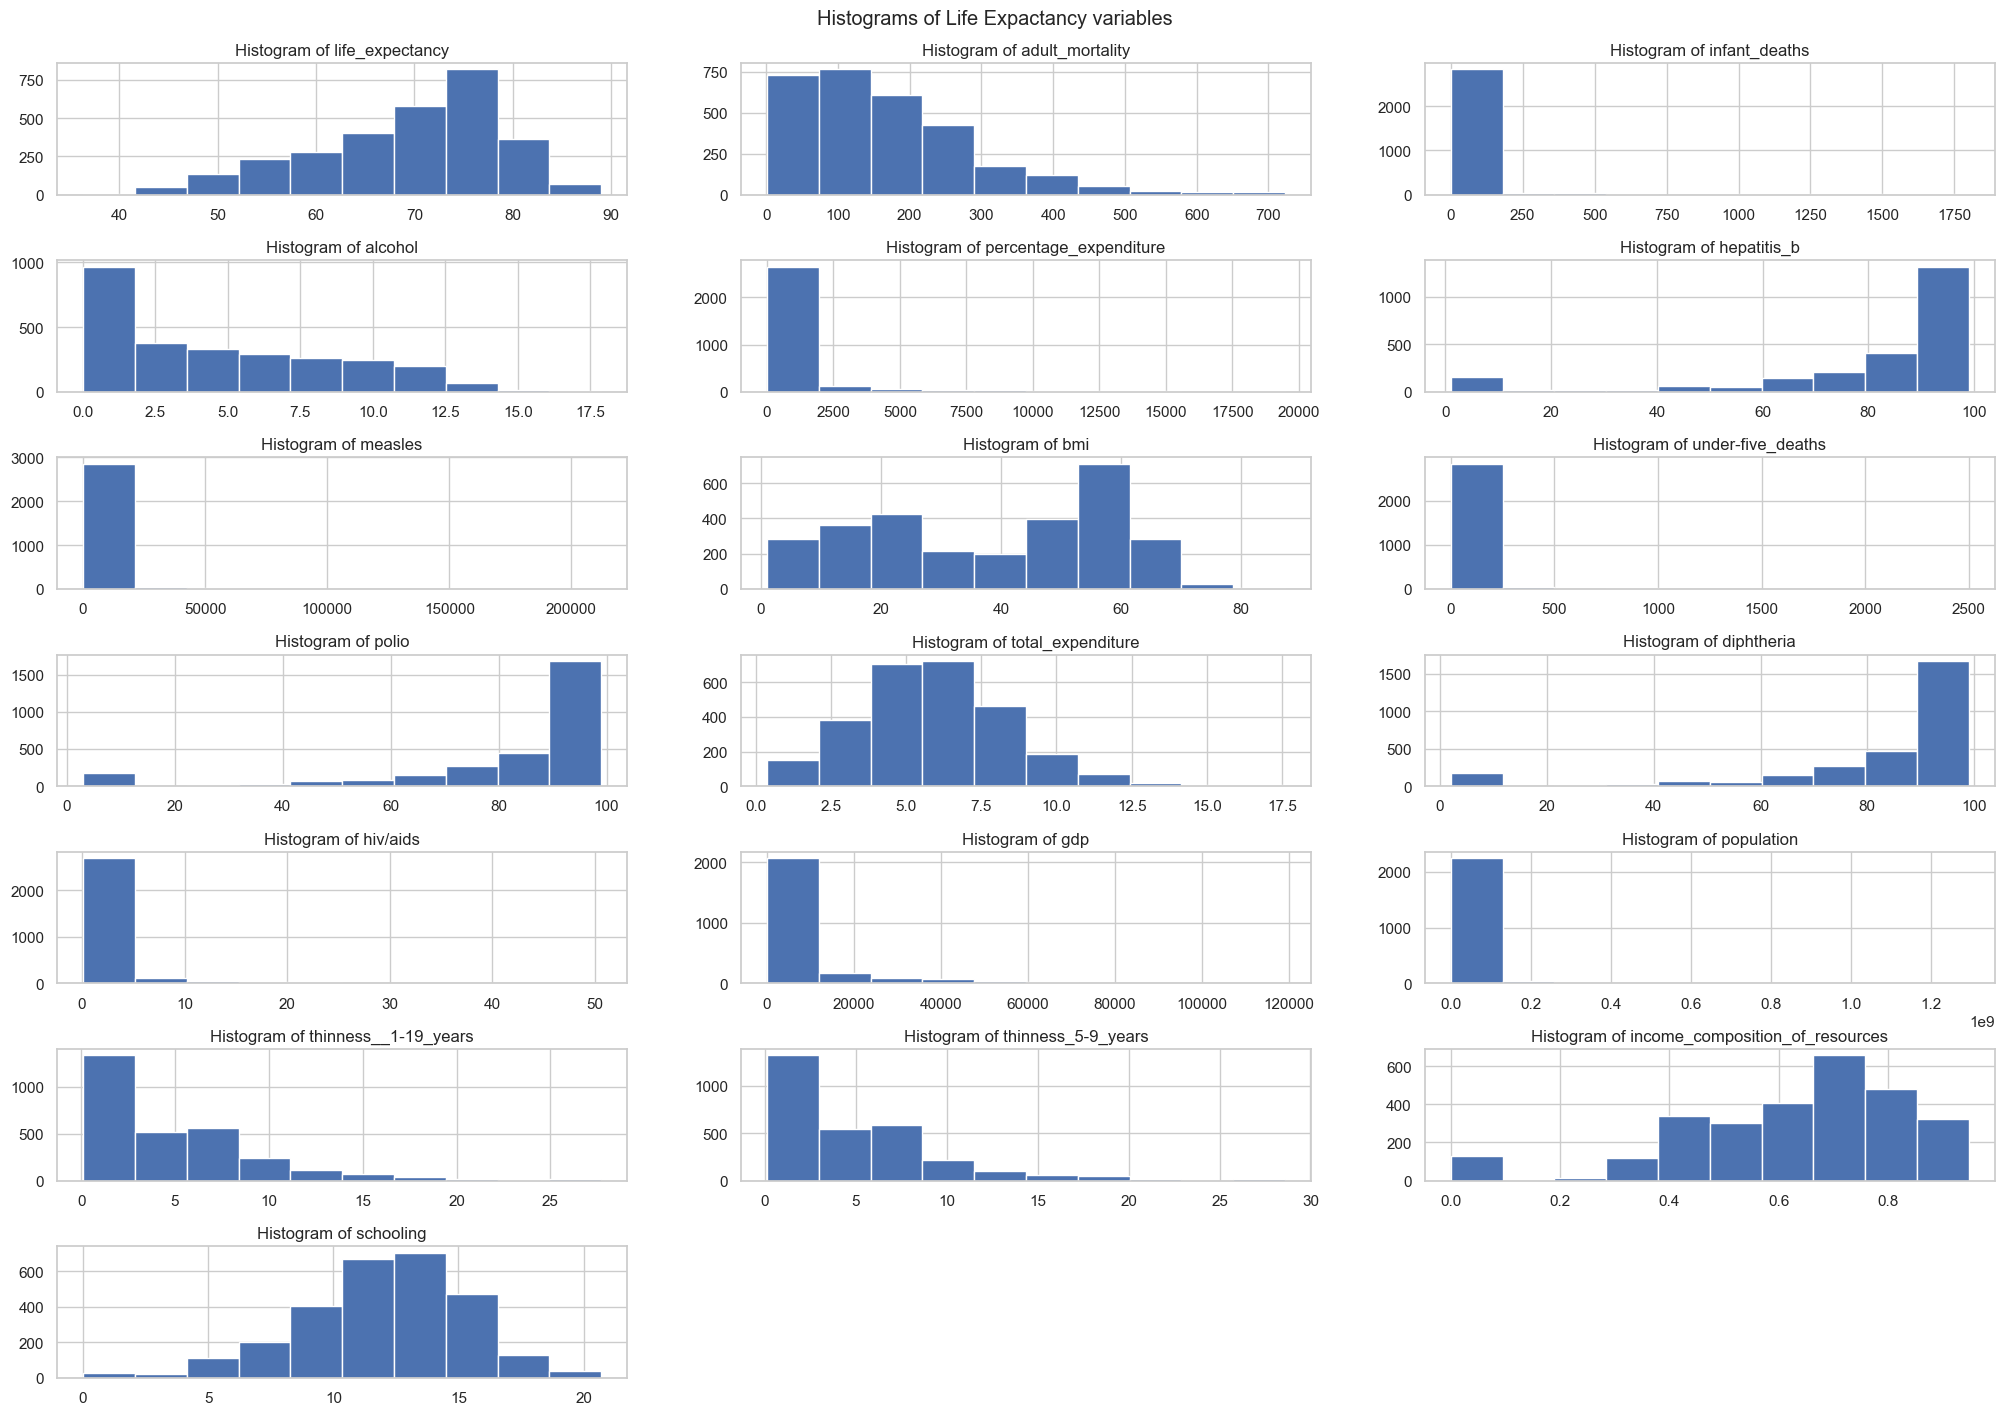

In [6]:
# Take a quick look at the variables the see what kind of distributions you are dealing with
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_df.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_df[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [7]:
# Take an initial look at nulls in the data
def null_report(df):
    categorical_cols = df.select_dtypes(include="category").columns
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

    # Create a rowcount variable
    df_len = len(df)

    # Calculated the width of the longest column
    max_col = len(max(df.columns, key=len))

    for col in categorical_cols: 
        # Use sorted function to generate a list of the 5 shortest categories
        short_cats = sorted(set(df[col]), key=len)[:5]
        print(f"First five shortest strings in '{col}': {short_cats}")

    # Look at null value information for continuous variables
    for col in categorical_cols:
        empty_strings = len(df.loc[df[col]==''])
        nulls = df[col].isna().sum()
        tot_nulls = empty_strings + nulls
        pct_nan = tot_nulls*100/df_len
        unique_vals = df[col].nunique()
        print(f"{col:<{max_col}}: {tot_nulls:>{5}} nulls | percent null: {pct_nan:>{5}.2f} | unique values: {unique_vals:>{24},.2f}")

    # Look a null value information for continuous variables
    for col in continuous_cols:
        nulls = df[col].isnull().sum()
        pct_null = nulls*100/df_len
        var = df[col].var()
        print(f"{col:<{max_col}}: {nulls:>{5}} nulls | percent null: {pct_null:>{5}.2f} | col variance: {var:>{25},.2f}")

null_report(life_expectancy_df)

First five shortest strings in 'country': ['Oman', 'Peru', 'Chad', 'Togo', 'Fiji']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :    10 nulls | percent null:  0.34 | col variance:                     90.70
adult_mortality                :    10 nulls | percent null:  0.34 | col variance:                 15,448.52
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :   194 nulls | percent null:  6.60 | col variance:                     16.42
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :   553 nulls | percent null: 18.82 | col variance:   

Number of null values: 1289


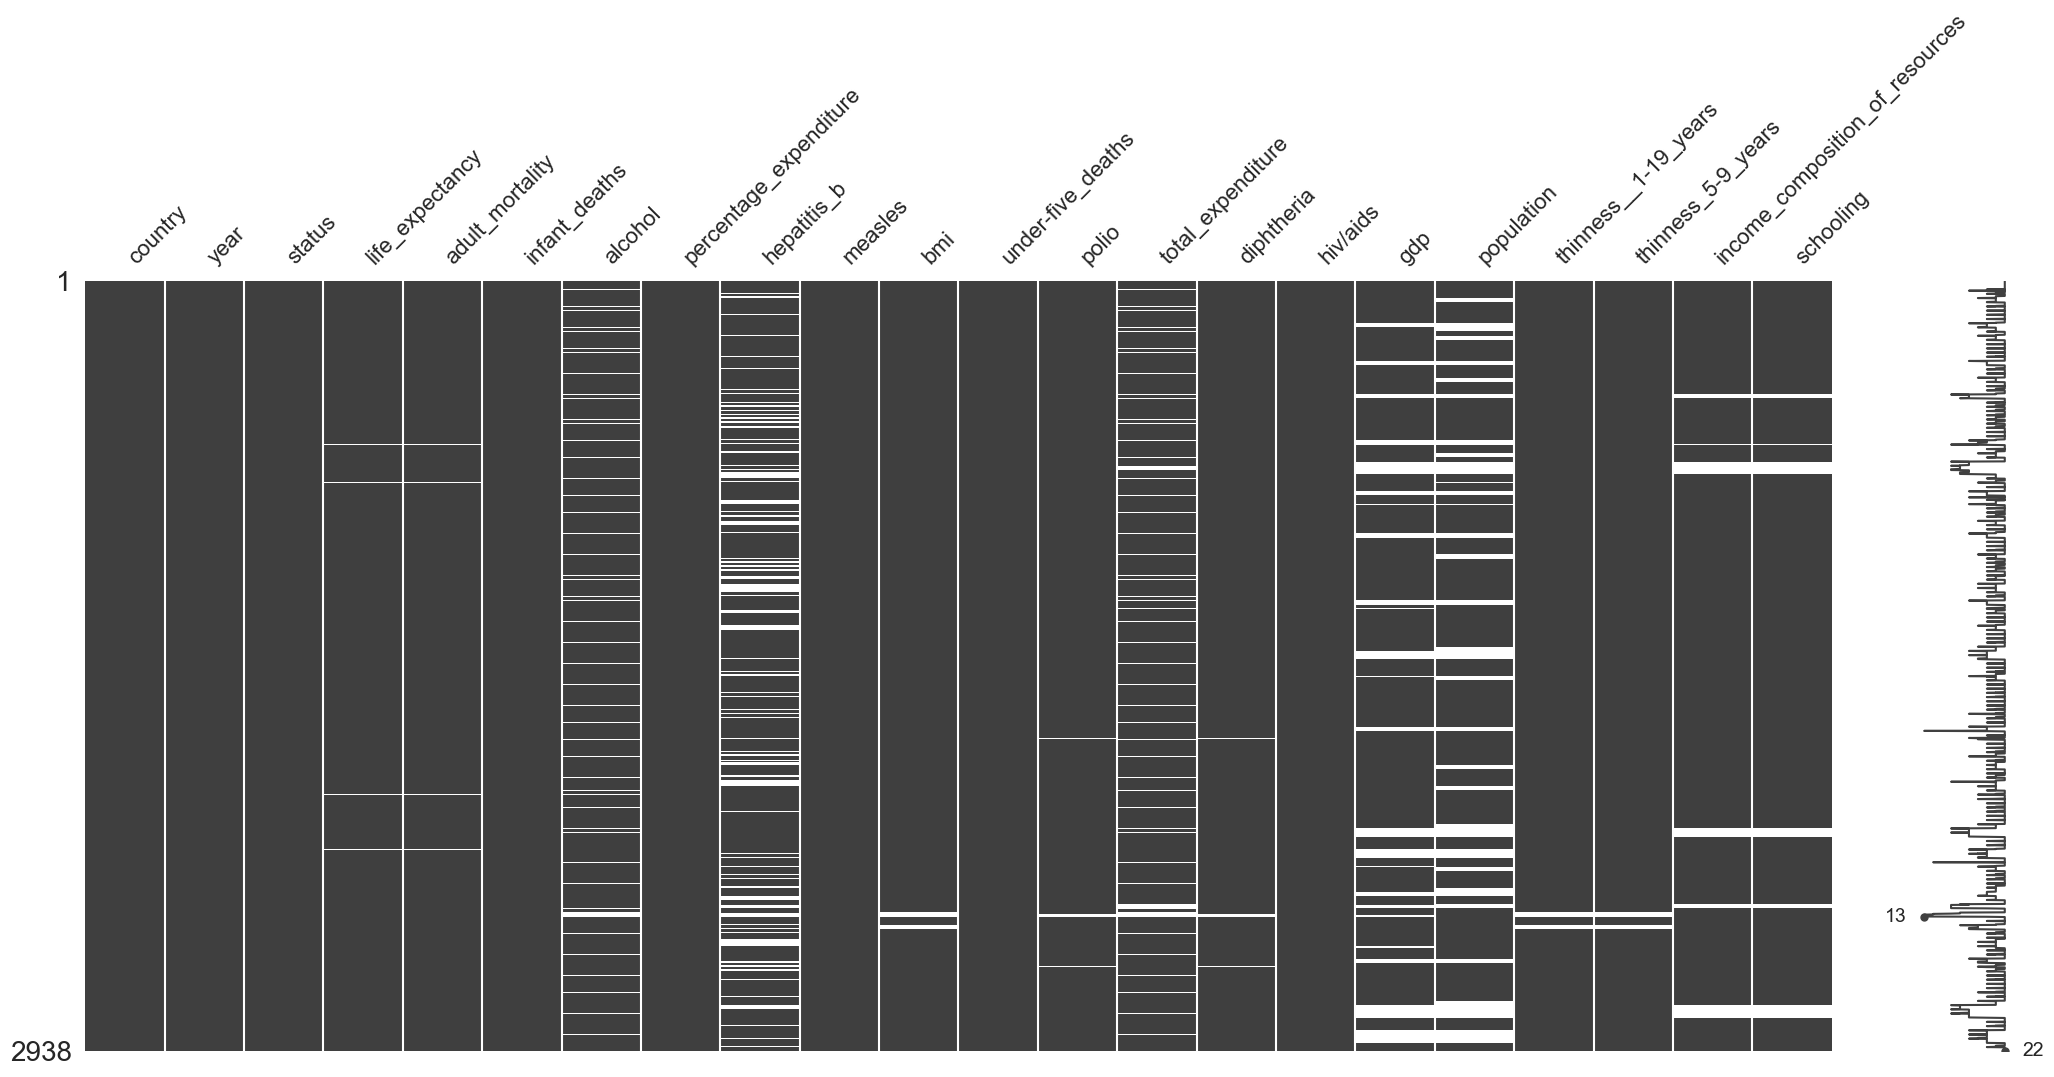

In [8]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")
        missingno.matrix(df)
        plt.show()
    else:
        print("No rows with null values found.")

report_null_entries(life_expectancy_df)

In [13]:
# Interpolate missing values and drop remaining null values
life_expectancy_interpolated = life_expectancy_df.copy()

# Try dropping the GDP and Populaion columns to help with null replacement
life_expectancy_interpolated.drop(["gdp","population"], axis=1, inplace=True)

# Get a list of countries to group by 
countries = life_expectancy_interpolated["country"].unique()

continuous_cols = life_expectancy_interpolated.select_dtypes(exclude= \
    ['object','category','datetime64[ns]']).columns

for country in countries: 
    life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]==country, continuous_cols] = \
        life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]== \
            country, continuous_cols].interpolate(limit_direction="both")

life_expectancy_interpolated.dropna(inplace=True)

null_report(life_expectancy_interpolated)

First five shortest strings in 'country': ['Oman', 'Peru', 'Chad', 'Togo', 'Fiji']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   163.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :     0 nulls | percent null:  0.00 | col variance:                     84.39
adult_mortality                :     0 nulls | percent null:  0.00 | col variance:                 15,246.61
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 15,298.47
alcohol                        :     0 nulls | percent null:  0.00 | col variance:                     15.63
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              2,684,403.15
hepatitis_b                    :     0 nulls | percent null:  0.00 | col variance:   

In [14]:
display(report_null_entries(life_expectancy_interpolated))



No rows with null values found.


None

## After interpolation there are still null values present in the data.  This is due to grouping the data by country prior to interpolation because there is insufficient data for some countries to interpolate.  My incliniation is to drop the nulls and move on, discuss with Abhimanyu 20191205

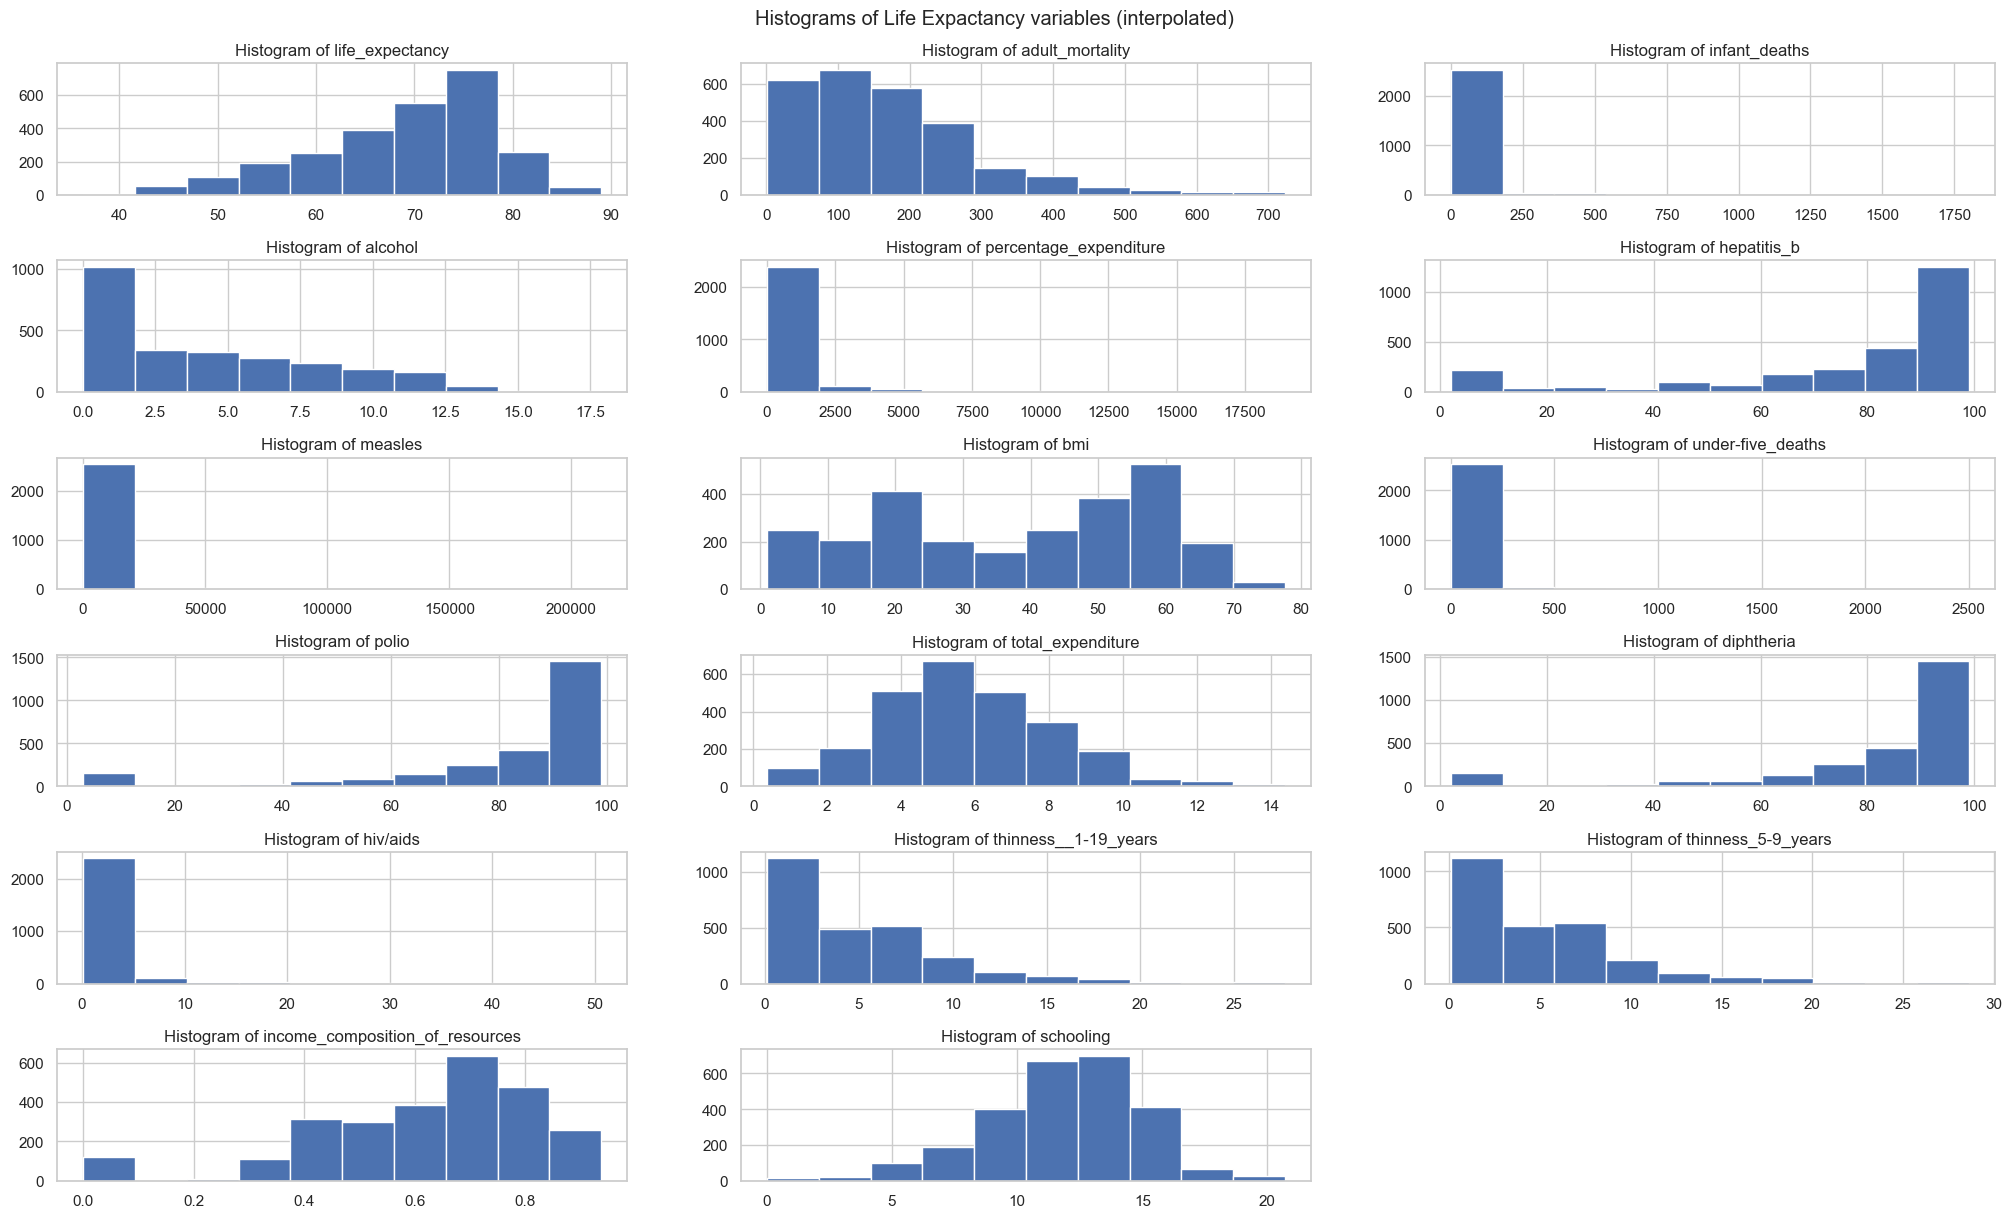

In [15]:
# Take a look at the variable distributions after interpolation
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_interpolated.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_interpolated[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables (interpolated)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

### Outlier Detection
_Z-Score_: To calculate Z-score, first, scale the variable so that its mean is 0 and it's standard deviation is 1.  Then measure how far a value is away from the mean (0) in terms of standard deviations (1).  The bigger the Z-score value, the farther it is from the mean and the more likely it is an outlier.

_Turkey's Method (IQR Method)_: This method consideres all values that are outside the threshold of 1.5 times the Interquartile Range (IQR) as outliers.  You can also changes the threshold to other values.

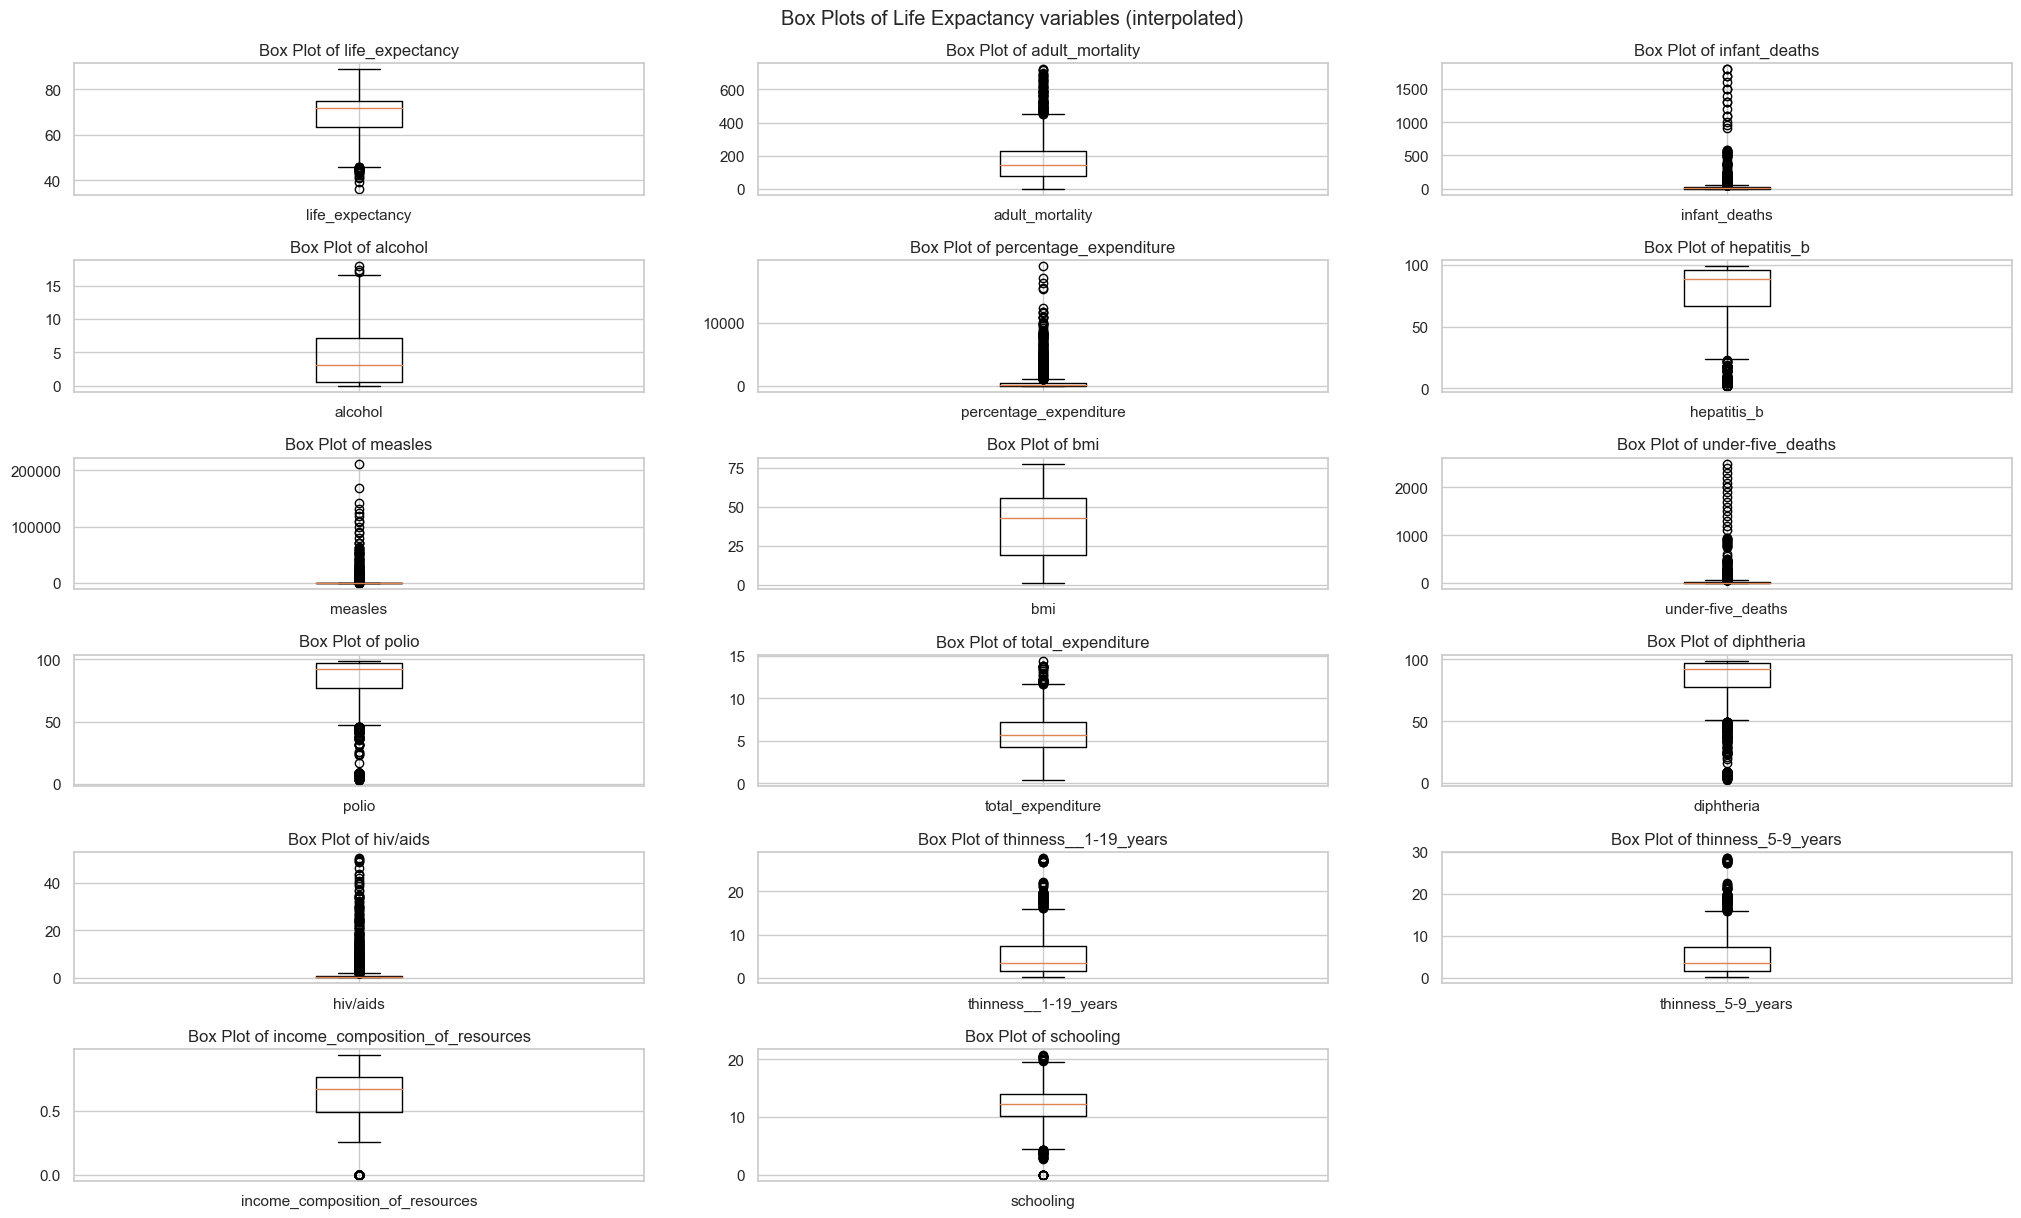

In [16]:
# Take an initial look at boxplots to get a feel for outliers in the data
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_interpolated.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_interpolated[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (interpolated)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [17]:
# Use Z-Scores to establish a threshold for outliers

for col in continuous_cols:
    z_scores = zscore(life_expectancy_interpolated[col])
    print(f"Variable: {col}:")
    for threshold in range(1,5): 
        print(f"\tZ-Score threshold: {threshold} | Number of outliers is: {len(np.where(z_scores > threshold)[0])}")
    print(100*"=")

Variable: life_expectancy:
	Z-Score threshold: 1 | Number of outliers is: 322
	Z-Score threshold: 2 | Number of outliers is: 17
	Z-Score threshold: 3 | Number of outliers is: 0
	Z-Score threshold: 4 | Number of outliers is: 0
Variable: adult_mortality:
	Z-Score threshold: 1 | Number of outliers is: 337
	Z-Score threshold: 2 | Number of outliers is: 121
	Z-Score threshold: 3 | Number of outliers is: 40
	Z-Score threshold: 4 | Number of outliers is: 11
Variable: infant_deaths:
	Z-Score threshold: 1 | Number of outliers is: 90
	Z-Score threshold: 2 | Number of outliers is: 56
	Z-Score threshold: 3 | Number of outliers is: 35
	Z-Score threshold: 4 | Number of outliers is: 26
Variable: alcohol:
	Z-Score threshold: 1 | Number of outliers is: 498
	Z-Score threshold: 2 | Number of outliers is: 95
	Z-Score threshold: 3 | Number of outliers is: 5
	Z-Score threshold: 4 | Number of outliers is: 0
Variable: percentage_expenditure:
	Z-Score threshold: 1 | Number of outliers is: 189
	Z-Score threshol

In [18]:
# Use the IQR Method to establish a threshold for outliers
for col in continuous_cols: 
    q75, q25 = np.percentile(life_expectancy_df[col], [75, 25])
    iqr = q75 - q25

    print(f"Variable: {col}")
    for threshold in np.arange(1,5,0.5): 
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        outliers = len((np.where((life_expectancy_df[col] > max_val) 
                      | (life_expectancy_df[col] < min_val))[0]))
        print(f"\tIQR Threshold: {threshold:>{4}.1f} | Outliers: {outliers}")
    print(100*"=")

Variable: life_expectancy
	IQR Threshold:  1.0 | Outliers: 0
	IQR Threshold:  1.5 | Outliers: 0
	IQR Threshold:  2.0 | Outliers: 0
	IQR Threshold:  2.5 | Outliers: 0
	IQR Threshold:  3.0 | Outliers: 0
	IQR Threshold:  3.5 | Outliers: 0
	IQR Threshold:  4.0 | Outliers: 0
	IQR Threshold:  4.5 | Outliers: 0
Variable: adult_mortality
	IQR Threshold:  1.0 | Outliers: 0
	IQR Threshold:  1.5 | Outliers: 0
	IQR Threshold:  2.0 | Outliers: 0
	IQR Threshold:  2.5 | Outliers: 0
	IQR Threshold:  3.0 | Outliers: 0
	IQR Threshold:  3.5 | Outliers: 0
	IQR Threshold:  4.0 | Outliers: 0
	IQR Threshold:  4.5 | Outliers: 0
Variable: infant_deaths
	IQR Threshold:  1.0 | Outliers: 419
	IQR Threshold:  1.5 | Outliers: 315
	IQR Threshold:  2.0 | Outliers: 226
	IQR Threshold:  2.5 | Outliers: 187
	IQR Threshold:  3.0 | Outliers: 158
	IQR Threshold:  3.5 | Outliers: 138
	IQR Threshold:  4.0 | Outliers: 130
	IQR Threshold:  4.5 | Outliers: 121
Variable: alcohol
	IQR Threshold:  1.0 | Outliers: 0
	IQR Threshold:

In [28]:
# Take a look at what effect winsorization has on the variables
life_expectancy_winsorized = life_expectancy_interpolated.copy()

for col in continuous_cols: 
    life_expectancy_winsorized[f"{col}_winsorized"] = winsorize(life_expectancy_winsorized[col], (0.19,0.19))

life_expectancy_winsorized.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 0 to 2937
Data columns (total 37 columns):
country                                       2608 non-null category
year                                          2608 non-null datetime64[ns]
status                                        2608 non-null category
life_expectancy                               2608 non-null float64
adult_mortality                               2608 non-null float64
infant_deaths                                 2608 non-null int64
alcohol                                       2608 non-null float64
percentage_expenditure                        2608 non-null float64
hepatitis_b                                   2608 non-null float64
measles                                       2608 non-null int64
bmi                                           2608 non-null float64
under-five_deaths                             2608 non-null int64
polio                                         2608 non-null float64
total_

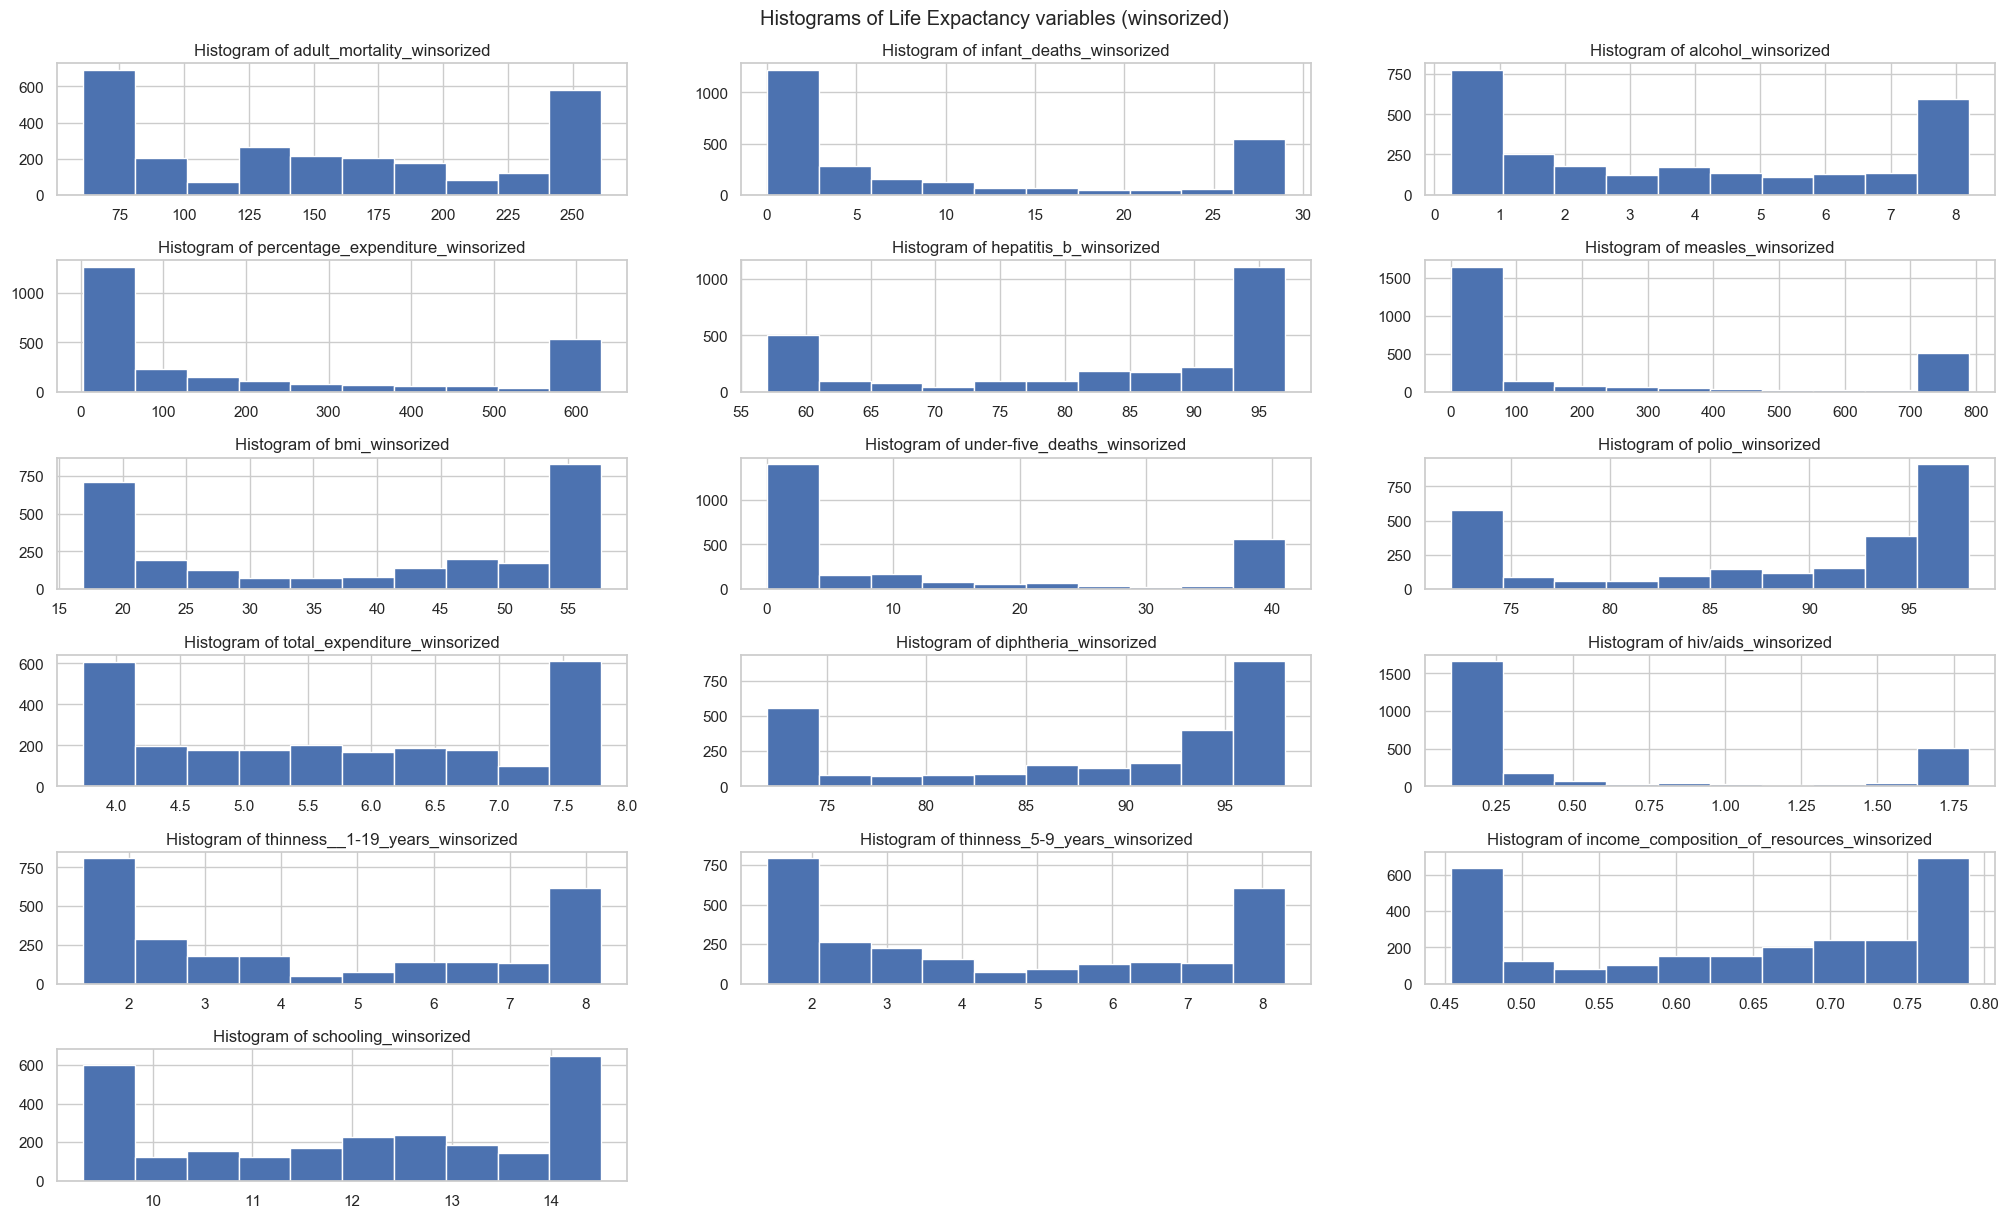

In [29]:
# Take a look at the variable distributions after winsorization focus on the winsorized variables
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_winsorized.columns[21:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_winsorized[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables (winsorized)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [30]:
# Take a look at what effect log transformation has on the variables
life_expectancy_log = life_expectancy_interpolated.copy()

for col in continuous_cols: 
    life_expectancy_log[f"{col}_log"] = np.log(life_expectancy_log[col])

life_expectancy_log.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2608 entries, 0 to 2937
Data columns (total 37 columns):
country                                2608 non-null category
year                                   2608 non-null datetime64[ns]
status                                 2608 non-null category
life_expectancy                        2608 non-null float64
adult_mortality                        2608 non-null float64
infant_deaths                          2608 non-null int64
alcohol                                2608 non-null float64
percentage_expenditure                 2608 non-null float64
hepatitis_b                            2608 non-null float64
measles                                2608 non-null int64
bmi                                    2608 non-null float64
under-five_deaths                      2608 non-null int64
polio                                  2608 non-null float64
total_expenditure                      2608 non-null float64
diphtheria                          

In [36]:
# Take a look at the variable distributions after log transformation focus on the log variables
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_log.columns[20:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_log[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables (log)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

ValueError: supplied range of [-inf, 7.495541943884256] is not finite

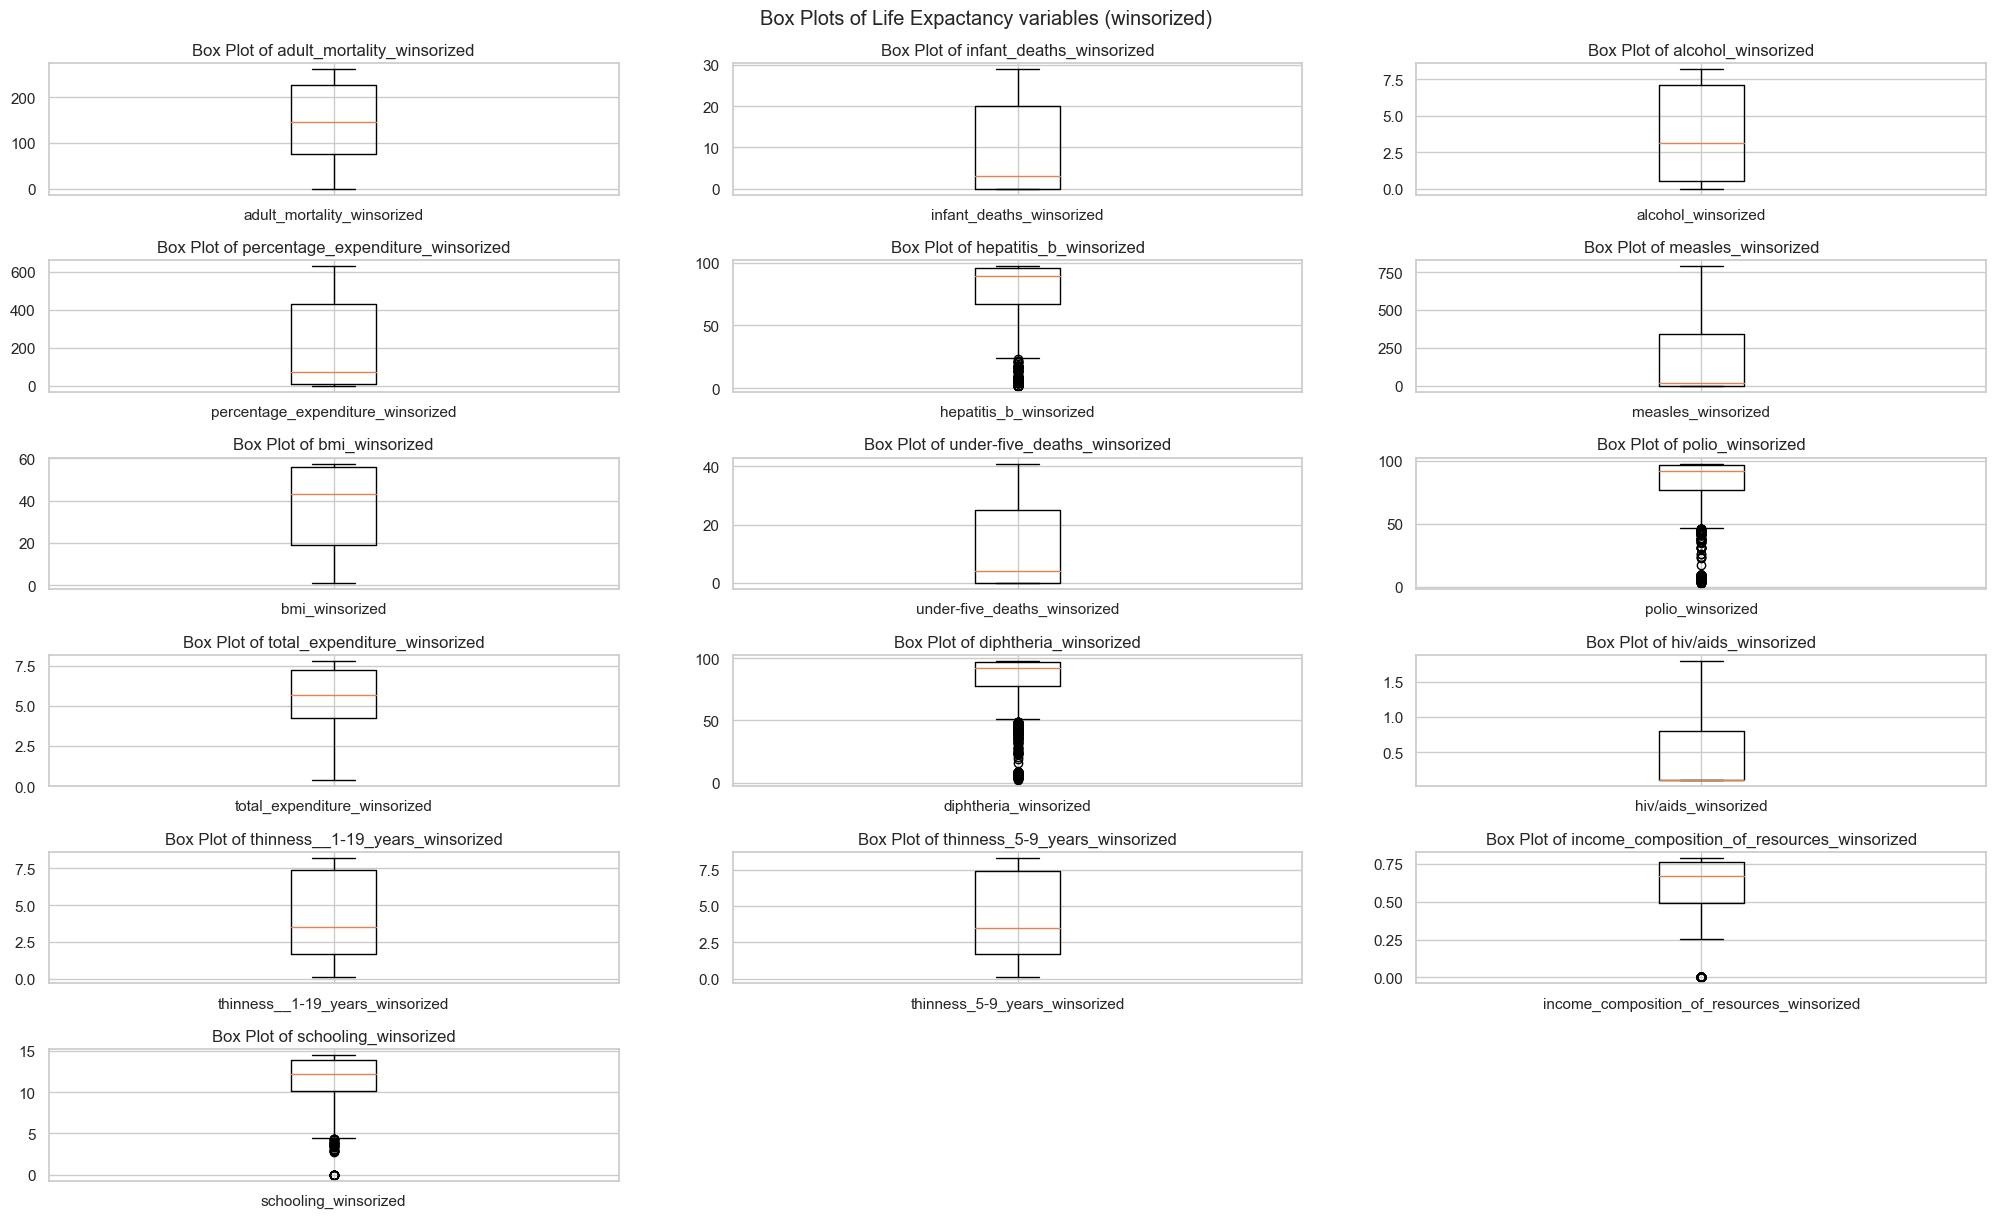

In [27]:
# Take an initial look at boxplots to get a feel for outliers in the winsorized data
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_winsorized.columns[21:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_winsorized[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (winsorized)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

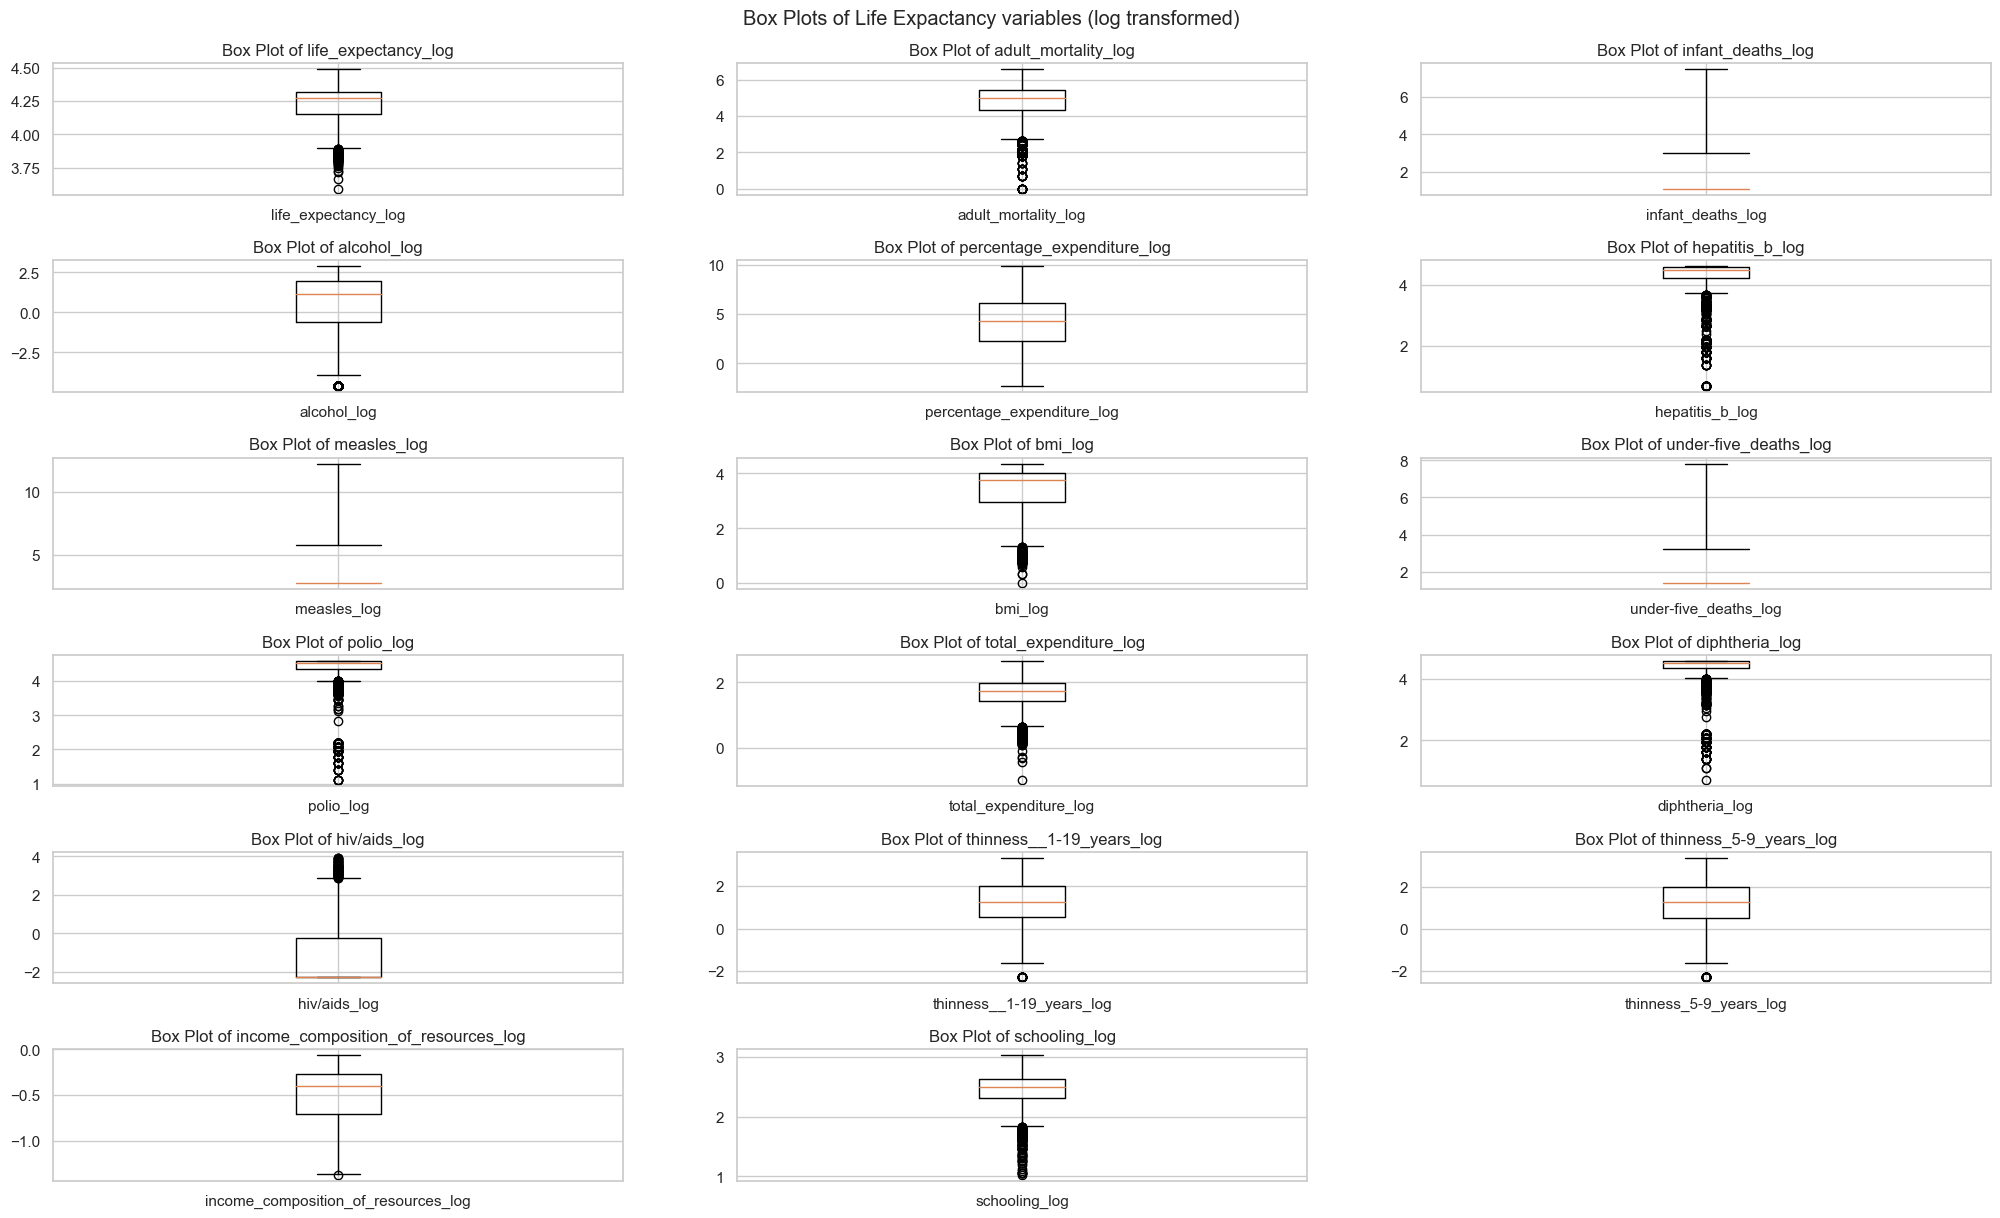

In [35]:
# Take an initial look at boxplots to get a feel for outliers in the log transformed data
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_log.columns[20:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_log[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (log transformed)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

### Bullet Two: Dealing with Nulls and outliers

#### _Nulls_
The Life Expectancy data covers the timeframe from 2000 to 2015, since it is timeseries data, interpolation seems to be the best fit for filling in missing informaiton.  I first grouped the data by country first, so that when interpolaiton is applied nulls are replaced with sensible values.  I had Pandas fill nulls both forward and backward when applying interpolation.  This did not remove all nulls from the data.  This stemms from the grouping mentioned earlier.  Not all of the countries report variable data for the lifetime of the data set and therefore there is no informaiton for Pandas to used as source data.  For the remaining null values I elected to drop the null rows.

#### _Outliers_
Generally, outliers have several undesirable effects on data being examined.  One, they can skew statistical measures like the mean which can lead to misrepresentations of the relationships in the data being examined.  Two, outliers can negatively impact machine learning models, which can be sensitive to extreme values. 

In [34]:
life_expectancy_log.columns[20:]

Index(['life_expectancy_log', 'adult_mortality_log', 'infant_deaths_log',
       'alcohol_log', 'percentage_expenditure_log', 'hepatitis_b_log',
       'measles_log', 'bmi_log', 'under-five_deaths_log', 'polio_log',
       'total_expenditure_log', 'diphtheria_log', 'hiv/aids_log',
       'thinness__1-19_years_log', 'thinness_5-9_years_log',
       'income_composition_of_resources_log', 'schooling_log'],
      dtype='object')